In [43]:
%pip install -Uqq scikit-learn tqdm numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [80]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [45]:
# load the MNIST dataset.
mnist = fetch_openml('mnist_784', version=1)

<Axes: xlabel='class', ylabel='count'>

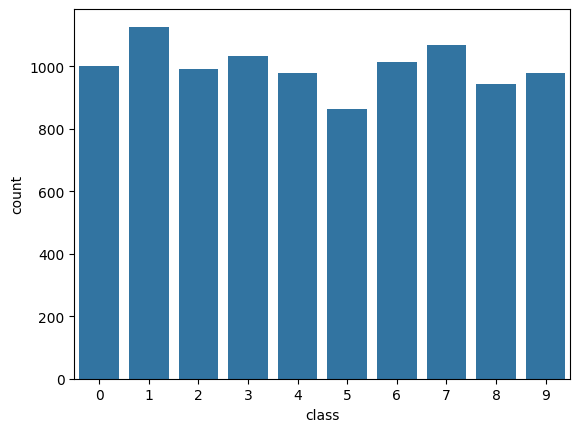

In [46]:
N_SAMPLES = 10_000
x, y = mnist['data'][:N_SAMPLES], mnist['target'][:N_SAMPLES]
Y = y.to_numpy().astype(np.uint8)
m_rows, n_cols = x.shape

# Plot the count of each label
sns.countplot(y.to_frame(), x='class')

In [47]:
# Create the features matrix X and add the bias element to each row
mat_X = np.c_[np.ones(x.shape[0]), x.to_numpy()]
mat_X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(10000, 785))

In [48]:
# Hot encode y.
Y_hot = np.zeros(shape=(m_rows, 10), dtype=np.uint8)
# Go over each row and place 1 at the index of the label, i.e label 3 will be placed at the 3rd index.
Y_hot[range(m_rows), Y] = 1
Y_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], shape=(10000, 10), dtype=uint8)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(mat_X, Y_hot, test_size=0.2, random_state=42)
f"X_train{X_train.shape}, X_test{X_test.shape}, Y_train{Y_train.shape}, Y_test{Y_test.shape}"

'X_train(8000, 785), X_test(2000, 785), Y_train(8000, 10), Y_test(2000, 10)'

In [50]:
y_lables = np.argmax(Y_train, axis=1)
y_lables

array([6, 2, 5, ..., 9, 0, 5], shape=(8000,))

In [ ]:
class PLA:
  def __init__(self, max_epochs = 1000):
    self.max_epochs = max_epochs
    
  def fit(self, X, Y):
    m, n_features = X.shape
    
    self.w_with_bias = np.zeros(n_features)
    self.pocket = self.w_with_bias
    min_err = float('inf')
      
    for _ in tqdm(range(self.max_epochs)):
      errors = 0
      for i in range(m):
        y_hat = self.predict_one(X[i])
        if y_hat != Y[i]:
          self.w_with_bias += Y[i] * X[i]
          errors += 1

      if errors < min_err:
          min_err = errors
          self.pocket = self.w_with_bias
        
      if errors == 0:
        break

  def predict_one(self, x):
    return np.sign(self.w_with_bias.T @ x)

  def predict(self, X):
    return np.apply_along_axis(self.predict_one, 1, X)

  def get_wb(self):
    return self.pocket

In [60]:
class PLAOneVsAll:
  def __init__(self, max_epochs = 1000):
    self.max_epochs = max_epochs

  def fit(self, X, Y):
    m, n_features = X.shape
    n_classes = Y.shape[1]
    self.w_mat = np.zeros(shape=(n_classes, n_features))

    y_signed = np.where(Y == 0, -1, 1)
    for i in tqdm(range(n_classes)):
      classifier = PLA(self.max_epochs)
      classifier.fit(X, y_signed[:, i])
      self.w_mat[i] = classifier.get_wb()

  def predict(self, X):
    """Gets the class with the highest confidence score"""
    return (self.w_mat @ X.T).argmax(axis=0)

In [61]:
one_vs_all = PLAOneVsAll()
one_vs_all.fit(X_train, Y_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.07s/it]


In [ ]:
def create_confusion_matrix(y_true, y_pred):
  m = len(y_true)
  
  confusion_matrix = np.zeros((10, 10), dtype=np.uint8)
  for i in range(m):
    confusion_matrix[y_true[i], y_pred[i]] += 1
    
  return confusion_matrix

In [96]:
def plot_confusion_matrix(actual, predicted, *, title=None, class_names=None):
    cm = create_confusion_matrix(actual, predicted)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


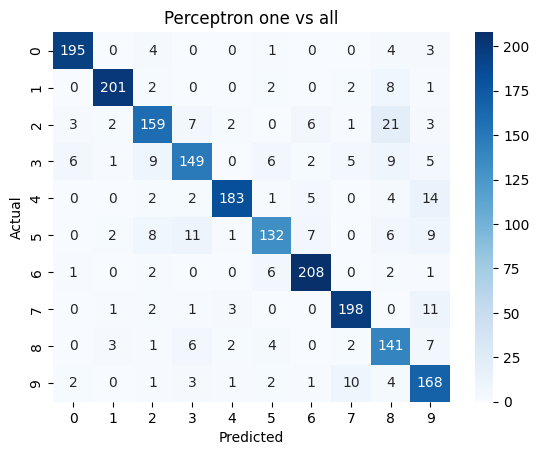

In [97]:
y_true = Y_test.argmax(axis=1)
y_pred = one_vs_all.predict(X_test)

plot_confusion_matrix(y_true, y_pred, title="Perceptron one vs all", class_names=range(10))
